# Plot the spectral widht data

You have to run ```run_multiprocessing_spec_width.py``` befor you can start plotting the data.<br>
This script will plot the spectral width in as function of time and frequency.<br>
The second part will extract distinct frequency bands and plot them as time series.

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

## Load spectral width data

In [2]:
# this is the path to save the figures
dirpath = '../output/covariance/figure/'
os.makedirs(dirpath, exist_ok=True)

In [3]:
def load_files(year,jdays,window_duration_sec,average,preprocessing_type):

    file_path = '../output/covariance/data/{}/'.format(year)

    for i, jday in enumerate(jdays):
        file_name = '{:03d}/{}_{}_{:03d}_wd{}_av{}'.format(jday,preprocessing_type,year,jday,int(window_duration_sec), average)

        ar = np.load(file_path+file_name+'.npz', allow_pickle=True)

        if i == 0:
            UTC_times = ar['UTC_times']
            frequencies = ar['frequencies']
            spectral_width = ar['spectral_width']/ar['n_sta']
            n_sta = np.full(len(ar['UTC_times']),ar['n_sta'])
        else:       
            spectral_width = np.concatenate((spectral_width, ar['spectral_width']/ar['n_sta']))
            UTC_times = np.concatenate((UTC_times, ar['UTC_times']))
            n_sta = np.concatenate((n_sta, np.full(len(ar['UTC_times'])-1,ar['n_sta'])))

    # to remove the last time per day 23:59:59 and only keep the first one of the new day 00:00
    UTC_times = np.array([t.datetime for i,t in enumerate(UTC_times,1) if t.second != 59]) 
    # add midnight of next day as datetime.datetime
    UTC_times = np.append(UTC_times,datetime.datetime.combine(UTC_times[-1].date()+
                                                         datetime.timedelta(days=1), 
                                                         datetime.datetime.min.time()))
    print('\n', UTC_times.shape, frequencies.shape, spectral_width.shape)
    
    return UTC_times, frequencies, n_sta, spectral_width

In [4]:
# define te parameters to specify which fileas you want to load
year = 2004
jdays = range(2,4+1)
hour = 0 # start hour (0 = midnight)
signal_duration_sec = 24 * 3600 # hour * sec

window_duration_sec = 30
average = 60 # number of time windows

preprocessing_type = 'OBS'

UTC_times, frequencies, n_sta, spectral_width = load_files(year,jdays,
                                                           window_duration_sec,
                                                           average,
                                                           preprocessing_type)


 (571,) (6000,) (570, 5999)


## Plot spectral width

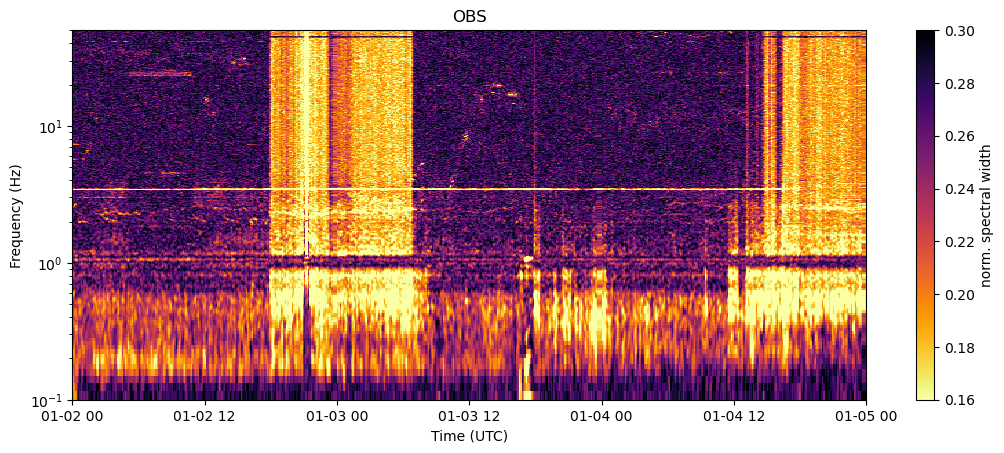

In [5]:
fig, ax = plt.subplots(figsize=(6.4*2, 4.8))
img = ax.pcolormesh(
    UTC_times, frequencies, spectral_width.T, rasterized=True, cmap="inferno_r",
    vmin=0.16, vmax=0.3)

# x axis
ax.set_xlabel('Time (UTC)')

# y axis
ax.set_yscale('log')
ax.set_ylim([1e-1, frequencies[-1]//2]) # up to Nyquiest frequency
ax.set_ylabel("Frequency (Hz)")

ax.set_title("{}".format(preprocessing_type))
plt.colorbar(img, ax=ax).set_label("norm. spectral width")
plt.savefig(dirpath+'{}_log_{}_{}_{}_dt{}_wd{}_av{}.png'.format(preprocessing_type,
                                                                 year,jdays[0],jdays[-1],
                                                                 signal_duration_sec,
                                                                 int(window_duration_sec),
                                                                 average),
            dpi=300, bbox_inches='tight')

## Extract Frequency bands

In [6]:
lower_freq = [2,4.5,8] # lower frequency limit
upper_freq = [5,8,16] # upper frequency limit

df_eig = pd.DataFrame()
df_eig['UTC'] = [(i+((UTC_times[1]-UTC_times[0])/2)) for i in UTC_times[:-1]] # to center time in bin
df_eig = df_eig.set_index('UTC')

for low, up in zip(lower_freq,upper_freq):
    idx = np.where(np.logical_and(frequencies>=low, frequencies<=up))[0]
    eig_selected_freq = spectral_width[:,idx[0]:idx[-1]] # first time than frequency
    eig_merge = np.mean(eig_selected_freq, axis=1)
    df_eig['frequ{}_{}'.format(low,up)] = eig_merge
df_eig

,frequ2_5,frequ4.5_8,frequ8_16
UTC,,,
2004-01-02 00:03:45,0.265823,0.270172,0.278043
2004-01-02 00:11:15,0.260822,0.270068,0.277164
2004-01-02 00:18:45,0.268604,0.271439,0.277401
2004-01-02 00:26:15,0.266856,0.271787,0.276959
2004-01-02 00:33:45,0.264617,0.270398,0.279482
...,...,...,...
2004-01-04 23:11:15,0.195613,0.203260,0.203029
2004-01-04 23:18:45,0.189127,0.197739,0.196908
2004-01-04 23:26:15,0.187925,0.192766,0.191735


In [7]:
df_eig_roll = df_eig.rolling('1H',center=True).median()
df_eig_roll

,frequ2_5,frequ4.5_8,frequ8_16
UTC,,,
2004-01-02 00:03:45,0.265823,0.270398,0.277401
2004-01-02 00:11:15,0.265753,0.270919,0.277489
2004-01-02 00:18:45,0.265823,0.271439,0.277401
2004-01-02 00:26:15,0.265842,0.270919,0.277282
2004-01-02 00:33:45,0.266111,0.271613,0.277282
...,...,...,...
2004-01-04 23:11:15,0.191223,0.197228,0.197093
2004-01-04 23:18:45,0.189127,0.197739,0.196908
2004-01-04 23:26:15,0.191446,0.198600,0.197283


## Plot frequency bands

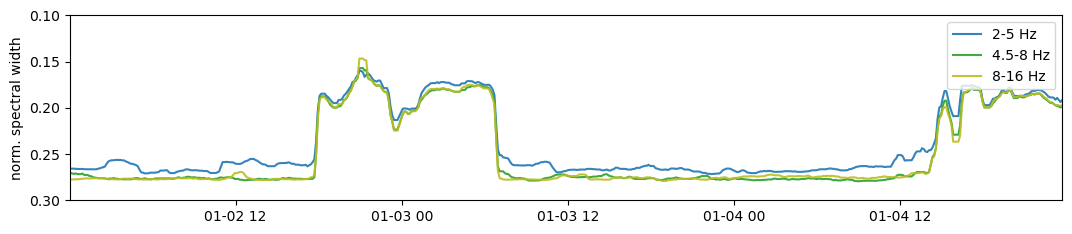

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6.4*2,4.8*0.5))
ax.plot(df_eig_roll.iloc[:,0], label='2-5 Hz', alpha=0.9, color='C0')
ax.plot(df_eig_roll.iloc[:,1], label='4.5-8 Hz', alpha=0.9, color='C2')
ax.plot(df_eig_roll.iloc[:,2], label='8-16 Hz', alpha=0.9, color='C8')

# x axis
ax.set_xlim(df_eig_roll.index[0],df_eig_roll.index[-1])

# y axis
ax.set_ylim(0.1,0.3)
ax.set_ylabel("norm. spectral width")
ax.invert_yaxis()
ax.legend(loc='upper right')
plt.savefig(dirpath+'{}_time_series.png'.format(preprocessing_type), dpi=300, bbox_inches='tight')
